In [3]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
from fancyimpute import KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import json
import os
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [4]:
# Read Files
X_train = pd.read_csv('../data/output/rf_imputed_X_train.csv', index_col=0)
X_test = pd.read_csv('../data/output/rf_imputed_X_test.csv', index_col = 0)

y_train = pd.read_csv('../data/output/y_train.csv')['isFraud']
y_test = pd.read_csv('../data/output/y_test.csv')['isFraud']

In [5]:
X_train.shape, y_train.shape

((472432, 308), (472432,))

In [6]:
X_test.shape, y_test.shape

((118108, 308), (118108,))

In [7]:
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,uid_cents_ct,C14_uid_std,uid_C13_ct,uid_V314_ct,uid_V127_ct,uid_V136_ct,uid_V309_ct,uid_V307_ct,uid_V320_ct,outsider15
0,68.5,4,13926.0,369.180356,150.0,1,142.0,1,315.0,87.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,29.0,4,2755.0,404.000000,150.0,2,102.0,1,325.0,87.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,59.0,4,4663.0,490.000000,150.0,4,166.0,2,330.0,87.0,...,1.0,0.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,1
3,50.0,4,18132.0,567.000000,150.0,2,117.0,2,476.0,87.0,...,1.0,0.0,23.0,1.0,82.0,10.0,9.0,81.0,10.0,0
4,50.0,1,4497.0,514.000000,150.0,2,102.0,1,420.0,87.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [8]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
472427    0
472428    0
472429    0
472430    0
472431    0
Name: isFraud, Length: 472432, dtype: int64

## Over/Under Sampling

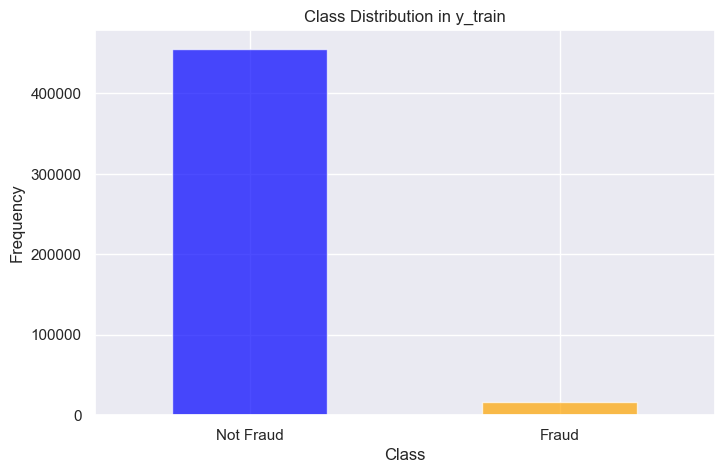

In [9]:
# Calculate value counts
value_counts = y_train.value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
value_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Class Distribution in y_train')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Not Fraud', 'Fraud'], rotation=0)
plt.show()

In [10]:
value_counts

isFraud
0    455833
1     16599
Name: count, dtype: int64

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Step 1: Reduce the majority class with RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.05, random_state=42)  # Adjust the sampling ratio for initial undersampling
X_under, y_under = rus.fit_resample(X_train, y_train)

print("Class distribution after RandomUnderSampler:")
print(y_under.value_counts())

# Step 2: Apply SMOTETomek to create a 70-30 balanced dataset
smote_tomek = SMOTETomek(sampling_strategy=0.4, random_state=42, n_jobs=-1)
X_resampled, y_resampled = smote_tomek.fit_resample(X_under, y_under)

print("Class distribution after SMOTETomek:")
print(y_resampled.value_counts())

Class distribution after RandomUnderSampler:
isFraud
0    331980
1     16599
Name: count, dtype: int64
Class distribution after SMOTETomek:
isFraud
0    328706
1    129518
Name: count, dtype: int64


In [12]:
def plot_2d_space(X_train, y_train,X,y,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

In [13]:
X_resampled.to_csv('../data/output/resampled_rf_imputed_X_train.csv')
y_resampled.to_csv('../data/output/resampled_y_train.csv')

In [14]:
# plot_2d_space(X_resampled, y_resampled, X_train, y_train,'SMOTE with Tomek Links')